In [33]:
#load important liberars
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from keras.optimizers import adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import glob
from PIL import Image
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [7]:
# load the train and test datsets
x_train=np.load('x_train.npy')
x_test= np.load('x_test.npy')
y_train=np.load('y_train_231.npy')
y_test=np.load('y_test_231.npy')

In [8]:
x_test[1]


array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

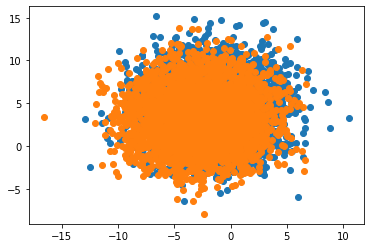

In [9]:
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_blobs
# generate dataset
X, y = make_blobs(n_samples=8000, centers=2, n_features=8000, random_state=1, cluster_std=3)
# create scatter plot for samples from each class
for class_value in range(231):
	# get row indexes for samples with this class
	row_ix = where(y == class_value)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [16]:
x

array([   0,    1,    2, ..., 7997, 7998, 7999])

In [10]:
#load lables of the training and test datset interms of row/col
y_trainr=np.load('y_trainr.npy')
y_trainc=np.load('y_trainc.npy')
y_testr=np.load('y_testr.npy')
y_testc=np.load('y_testc.npy')

In [11]:
# one-hoet-encoding of 231 classes
Y_train =np_utils.to_categorical(y_train, 231)
Y_test = np_utils.to_categorical(y_test, 231)

In [12]:
#just one-hot-encoding (row/col--33/7 class)
Y_trainr =np_utils.to_categorical(y_trainr, 33)
Y_testr = np_utils.to_categorical(y_testr, 33)

Y_trainc =np_utils.to_categorical(y_trainc, 7)
Y_testc = np_utils.to_categorical(y_testc, 7)

In [59]:
#since we set the include_top  as "False" the fully-connected output layers of the model is not loaded
inputshape=Input(shape=(32,32,3))
model=VGG16(weights="imagenet",include_top=False,input_tensor=inputshape)


In [60]:
# function to freezing the layers of the orginal as per our need... we just set
# the tune_layer value for the model layers that should not be freez--->for 231 class

def fine_tune(tune_layer=0):
    if tune_layer>0:
        for layer in model.layers[:-tune_layer]:
            layer.trainable=False
    else:
        for layer in model.layers:
            layer.trainable = False
            
            
    last_conv_out= model.output
    flatten= Flatten()(last_conv_out)
    fc1= Dense(1024, activation='relu')(flatten)
    fc2= Dense(2048, activation='relu')(fc1)
    outputs_231=Dense(231, activation='softmax')(fc2)
    
    model_231=Model(inputs=model.inputs, outputs=outputs_231)
    
    model_231.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_231

In [61]:
trans_model_231=fine_tune(2)

In [62]:
trans_model_231.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [63]:
# Early Stopping to prevent overfitting and checkpoint to save model at each epoch231
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)
checkpoint = ModelCheckpoint('/vgg/vgg231_fin2{epoch:01d}.hdf5', period=5)

In [56]:
hist = trans_model_231.fit(x_train, Y_train, batch_size=32, epochs=10,
                  verbose=1, validation_split=0.1,shuffle=True)

Epoch 1/10
2025/2025 [==============================] - 362s 179ms/step - loss: 5.4466 - accuracy: 0.0049 - val_loss: 5.4432 - val_accuracy: 0.0046
Epoch 2/10
2025/2025 [==============================] - 240s 118ms/step - loss: 5.4419 - accuracy: 0.0052 - val_loss: 5.4438 - val_accuracy: 0.0047
Epoch 3/10
2025/2025 [==============================] - 216s 107ms/step - loss: 5.4417 - accuracy: 0.0052 - val_loss: 5.4442 - val_accuracy: 0.0047
Epoch 4/10
2025/2025 [==============================] - 223s 110ms/step - loss: 5.4417 - accuracy: 0.0048 - val_loss: 5.4443 - val_accuracy: 0.0046
Epoch 5/10
2025/2025 [==============================] - 211s 104ms/step - loss: 5.4416 - accuracy: 0.0050 - val_loss: 5.4445 - val_accuracy: 0.0046
Epoch 6/10
2025/2025 [==============================] - 211s 104ms/step - loss: 5.4416 - accuracy: 0.0051 - val_loss: 5.4445 - val_accuracy: 0.0046
Epoch 7/10
2025/2025 [==============================] - 212s 105ms/step - loss: 5.4417 - accuracy: 0.0051 - val_

In [57]:
score = trans_model_231.evaluate(x_test,Y_test, batch_size=16, verbose=1)


500/500 [==============================] - 18s 35ms/step - loss: 5.4439 - accuracy: 0.0027


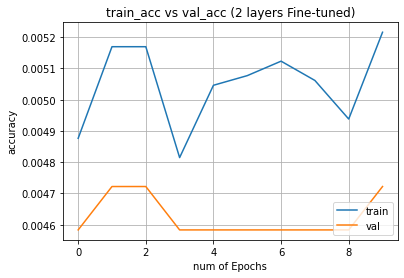

In [58]:
# visualizing  accuracy per  train1
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(10)

# to print training  accuracy vs validation accuracy
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc (2 layers Fine-tuned)')
plt.grid(True)
plt.legend(['train', 'val'], loc=4)
plt.show()


In [46]:
# model_0 fine tune
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pred = trans_model_231.predict(x_test)
y_pred = pred.argmax(axis=-1)
y_true = [np.argmax(p) for p in Y_test]
#finetune 1
print(classification_report(y_true, y_pred))
matrix = confusion_matrix(y_true, y_pred)
acceach2=matrix.diagonal()/matrix.sum(axis=1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        38
           5       0.00      0.00      0.00        32
           6       0.00      0.00      0.00        38
           7       0.00      0.00      0.00        35
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00        42
          11       0.00      0.00      0.00        25
          12       0.00      0.00      0.00        34
          13       0.00      0.00      0.00        31
          14       0.00      0.00      0.00        36
          15       0.00      0.00      0.00        31
          16       0.00      0.00      0.00        32
          17       0.00    

/home/nbm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nbm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nbm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
acceach2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

NameError: name 'trans_model_231' is not defined

In [133]:
acceach

array([0.89473684, 0.88888889, 0.57142857, 0.80769231, 0.78947368,
       0.96875   , 0.86842105, 0.68571429, 0.74074074, 0.85      ,
       0.92857143, 0.76      , 0.97058824, 0.87096774, 0.88888889,
       0.90322581, 0.78125   , 0.96      , 0.92105263, 0.94285714,
       0.85294118, 0.91304348, 0.89473684, 0.89473684, 0.81818182,
       0.82352941, 0.96969697, 0.92592593, 0.91176471, 0.93548387,
       0.89285714, 0.92307692, 0.68421053, 0.94444444, 0.95833333,
       0.93548387, 0.9       , 0.84375   , 0.625     , 0.90322581,
       0.85714286, 0.77419355, 0.74      , 0.85185185, 0.68292683,
       0.88235294, 0.80487805, 0.71428571, 0.89285714, 0.66666667,
       0.82051282, 0.78378378, 0.75609756, 0.82926829, 0.74193548,
       0.86842105, 0.97368421, 0.72972973, 0.75862069, 0.86363636,
       0.63636364, 0.72727273, 0.86666667, 0.79310345, 0.83333333,
       0.75      , 0.78125   , 0.45652174, 0.86666667, 0.6969697 ,
       0.75609756, 0.96      , 0.87234043, 0.90243902, 0.66666

In [128]:
#finetune 1
print(classification_report(y_true, y_pred))
matrix = confusion_matrix(y_true, y_pred)
acceach1=matrix.diagonal()/matrix.sum(axis=1)

              precision    recall  f1-score   support

           0       0.85      0.92      0.89        38
           1       0.86      0.86      0.86        36
           2       0.70      0.75      0.72        28
           3       0.60      0.96      0.74        26
           4       0.80      0.84      0.82        38
           5       0.91      0.97      0.94        32
           6       0.94      0.84      0.89        38
           7       0.92      0.66      0.77        35
           8       0.96      0.89      0.92        27
           9       0.87      0.82      0.85        40
          10       0.79      0.90      0.84        42
          11       0.70      0.84      0.76        25
          12       0.97      0.88      0.92        34
          13       0.87      0.87      0.87        31
          14       0.82      0.92      0.87        36
          15       0.91      0.94      0.92        31
          16       0.84      0.81      0.83        32
          17       0.63    

In [129]:
#finetune1
sum=0
for i in range(len(acceach1)):
    sum=sum+acceach1[i]
    print(i, acceach1[i])

print(sum)

0 0.9210526315789473
1 0.8611111111111112
2 0.75
3 0.9615384615384616
4 0.8421052631578947
5 0.96875
6 0.8421052631578947
7 0.6571428571428571
8 0.8888888888888888
9 0.825
10 0.9047619047619048
11 0.84
12 0.8823529411764706
13 0.8709677419354839
14 0.9166666666666666
15 0.9354838709677419
16 0.8125
17 0.96
18 0.9210526315789473
19 0.9714285714285714
20 0.8235294117647058
21 0.9130434782608695
22 0.9210526315789473
23 0.8947368421052632
24 0.8636363636363636
25 0.9117647058823529
26 0.9696969696969697
27 0.8888888888888888
28 0.8823529411764706
29 0.9354838709677419
30 0.8214285714285714
31 0.9487179487179487
32 0.5526315789473685
33 0.9444444444444444
34 0.9166666666666666
35 0.9032258064516129
36 0.925
37 0.78125
38 0.7916666666666666
39 0.9032258064516129
40 0.9285714285714286
41 0.8387096774193549
42 0.58
43 0.8888888888888888
44 0.8292682926829268
45 0.8823529411764706
46 0.8292682926829268
47 0.8571428571428571
48 0.75
49 0.625
50 0.8205128205128205
51 0.7837837837837838
52 0.8292

In [151]:
pred = trans_model_231.predict(x_test)
y_pred = pred.argmax(axis=-1)
y_true = [np.argmax(p) for p in Y_test]
#finetune 2
print(classification_report(y_true, y_pred))
matrix = confusion_matrix(y_true, y_pred)
acceach2=matrix.diagonal()/matrix.sum(axis=1)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        38
           1       0.96      0.75      0.84        36
           2       0.79      0.79      0.79        28
           3       0.89      0.92      0.91        26
           4       0.94      0.87      0.90        38
           5       0.97      0.94      0.95        32
           6       0.91      0.82      0.86        38
           7       0.81      0.83      0.82        35
           8       0.60      0.96      0.74        27
           9       0.82      0.93      0.87        40
          10       0.97      0.86      0.91        42
          11       0.94      0.68      0.79        25
          12       0.86      0.88      0.87        34
          13       0.82      0.87      0.84        31
          14       0.91      0.83      0.87        36
          15       0.78      0.90      0.84        31
          16       0.82      0.84      0.83        32
          17       0.68    

In [153]:
#finetune1
sum=0
for i in range(len(acceach2)):
    sum=sum+acceach2[i]
    print(i, acceach2[i])

print(sum)

0 0.8947368421052632
1 0.75
2 0.7857142857142857
3 0.9230769230769231
4 0.868421052631579
5 0.9375
6 0.8157894736842105
7 0.8285714285714286
8 0.9629629629629629
9 0.925
10 0.8571428571428571
11 0.68
12 0.8823529411764706
13 0.8709677419354839
14 0.8333333333333334
15 0.9032258064516129
16 0.84375
17 0.92
18 0.6578947368421053
19 0.8571428571428571
20 0.8823529411764706
21 0.8695652173913043
22 0.8947368421052632
23 0.8421052631578947
24 0.8636363636363636
25 0.8823529411764706
26 0.9696969696969697
27 0.9629629629629629
28 0.8823529411764706
29 0.9354838709677419
30 0.7857142857142857
31 0.9487179487179487
32 0.631578947368421
33 0.9444444444444444
34 0.9583333333333334
35 0.8064516129032258
36 0.9
37 0.8125
38 0.8333333333333334
39 0.8064516129032258
40 0.8214285714285714
41 0.8709677419354839
42 0.66
43 0.8518518518518519
44 0.8048780487804879
45 0.8823529411764706
46 0.7073170731707317
47 0.7714285714285715
48 0.7857142857142857
49 0.9583333333333334
50 0.8717948717948718
51 0.7027

In [31]:
# function to freezing the layers of the orginal as per our need... we just set
# the tune_layer value for the model layers that should not be freez--->for 33/7class

def fine_tunerc(tune_layerrc=0):
    if tune_layerrc>0:
        for layer in model.layers[:-tune_layerrc]:
            layer.trainable=False
    else:
        for layer in model.layers:
            layer.trainable = False
            
            
    last_conv_out= model.output
    flatten= Flatten()(last_conv_out)
    fc1= Dense(1024, activation='relu')(flatten)
    fc2= Dense(2048, activation='relu')(fc1)
    inner =Dropout(rate=0.5)(fc2)
    out_r =Dense(33 ,activation="softmax")(inner)
    out_c =Dense(7,activation="softmax")(inner)

    model_rc=Model(inputs=model.inputs, outputs=[out_r, out_c])
    
    model_rc.compile(optimizer='adam',loss=['categorical_crossentropy','categorical_crossentropy'],
                     metrics=['accuracy'])
    
    return model_rc

In [34]:
trans_model_rc=fine_tunerc(2)

In [35]:
# Early Stopping to prevent overfitting and checkpoint to save model at each epoch231
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)
checkpoint = ModelCheckpoint('./vgg/modelVGGrc2{epoch:01d}.hdf5', period=1)

In [36]:
hist_rc = trans_model_rc.fit(x_train, [Y_trainr, Y_trainc], batch_size=32, epochs=10,
                  verbose=1, validation_split=0.1,shuffle=True)

Epoch 1/10
2025/2025 [==============================] - 326s 161ms/step - loss: 5.4427 - dense_12_loss: 3.4967 - dense_13_loss: 1.9460 - dense_12_accuracy: 0.0302 - dense_13_accuracy: 0.1411 - val_loss: 5.4428 - val_dense_12_loss: 3.4969 - val_dense_13_loss: 1.9459 - val_dense_12_accuracy: 0.0306 - val_dense_13_accuracy: 0.1479
Epoch 2/10
2025/2025 [==============================] - 323s 159ms/step - loss: 5.4427 - dense_12_loss: 3.4966 - dense_13_loss: 1.9460 - dense_12_accuracy: 0.0313 - dense_13_accuracy: 0.1411 - val_loss: 5.4429 - val_dense_12_loss: 3.4970 - val_dense_13_loss: 1.9459 - val_dense_12_accuracy: 0.0307 - val_dense_13_accuracy: 0.1479
Epoch 3/10
2025/2025 [==============================] - 323s 159ms/step - loss: 5.4427 - dense_12_loss: 3.4966 - dense_13_loss: 1.9460 - dense_12_accuracy: 0.0310 - dense_13_accuracy: 0.1389 - val_loss: 5.4427 - val_dense_12_loss: 3.4968 - val_dense_13_loss: 1.9459 - val_dense_12_accuracy: 0.0278 - val_dense_13_accuracy: 0.1479
Epoch 4/10

In [185]:
trans_model_rc.save('trans_model_rc_0.hdf5')

In [24]:
score = trans_model_rc.evaluate(x_test,[Y_testr,Y_testc],batch_size=16, verbose=1)

500/500 [==============================] - 37s 73ms/step - loss: 5.4422 - dense_6_loss: 3.4966 - dense_7_loss: 1.9456 - dense_6_accuracy: 0.0289 - dense_7_accuracy: 0.1481


In [25]:
print('Test lossr:', score[1])
print('Test lossc:', score[2])
print('Test accuracyr:', score[3])
print('Test accuracyc:', score[4])


Test lossr: 3.496608257293701
Test lossc: 1.9455894231796265
Test accuracyr: 0.028875000774860382
Test accuracyc: 0.14812499284744263


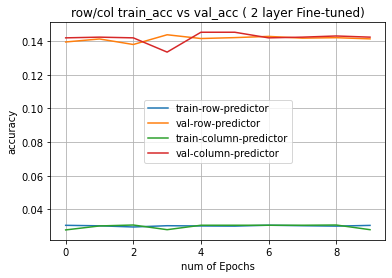

In [30]:
trr_acc = hist_rc.history['dense_6_accuracy']
valr_acc = hist_rc.history['dense_7_accuracy']
trc_acc = hist_rc.history['val_dense_6_accuracy']
valc_acc = hist_rc.history['val_dense_7_accuracy']
epochs=range(10)


# to print training  accuracy vs validation accuracy
plt.plot(epochs, trr_acc)
plt.plot(epochs, valr_acc)
plt.plot(epochs, trc_acc)
plt.plot(epochs, valc_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('row/col train_acc vs val_acc ( 2 layer Fine-tuned)')
plt.grid(True)
plt.legend(['train-row-predictor', 'val-row-predictor','train-column-predictor', 'val-column-predictor'], loc='center')
plt.show()

In [127]:
pred = trans_model_rc.predict(x_test)[1]
y_pred = [np.argmax(p) for p in pred]
y_true = [np.argmax(p) for p in Y_testc]

In [128]:
accuracy_score(y_true,y_pred)

0.86225

In [163]:
model.layers[:-1]

In [164]:
#plot accuracy as a function of fine-tuned model
# visualizing  accuracy per epoch
accuracy_231 = [0.8172500133514404,0.8261250257492065,0.8240000009536743,0.002749999985098839]
accuracy_row = [0.8987500071525574 ,0.8981249928474426,0.9017500281333923,0.028999999165534973]
accuracy_col = [0.8482499718666077 ,0.8482499718666077,0.8622499704360962,0.1469999998807907]
no_of_fine_tune =range(0,4)

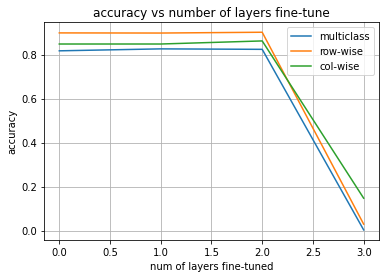

In [166]:
plt.plot(no_of_fine_tune, accuracy_231)
plt.plot(no_of_fine_tune, accuracy_row)
plt.plot(no_of_fine_tune, accuracy_col)
plt.xlabel('num of layers fine-tuned')
plt.ylabel('accuracy')
plt.title('accuracy vs number of layers fine-tune')
plt.grid(True)
plt.legend(['multiclass', 'row-wise','col-wise'], loc='upper right')
plt.show()

In [197]:
no_of_fine_tune

range(0, 3)

In [198]:
epochs = range(1,35)

In [199]:
print(epochs)

range(1, 35)


In [53]:
#summery of erros
A0= 0.8172500133514404 # accuracy of a model by freexing all layers of the VGGnet
A1=0.8261250257492065  #freeze all except the last one conv block
A2=0.8240000009536743  
A3=0.002749999985098839

In [54]:
# #error
# E0=1-A0
# E1=1-A1
# E2=1-A2
# E3=1-A3

In [57]:
err0p=A0+2 * np.sqrt(A0*(1-A0)/8_000)
err1p=A1+2 * np.sqrt(A1*(1-A1)/8_000)
err2p=A2+2 * np.sqrt(A2*(1-A2)/8_000)
err3p=A3+2 * np.sqrt(A3*(1-A3)/8_000)

In [58]:
err0n=A0-2 * np.sqrt(A0*(1-A0)/8_000)
err1n=A1-2 * np.sqrt(A1*(1-A1)/8_000)
err2n=A2-2 * np.sqrt(A2*(1-A2)/8_000)
err3n=A3-2 * np.sqrt(A3*(1-A3)/8_000)

In [61]:
errp=[err0p,err1p,err2p, err3p]
errn=[err0n,err1n,err2n, err3n]

In [154]:
A_model_0=acceach0
A_model_1=acceach1
A_model_2=acceach2
A_model_3=acceach0

In [155]:
A_model_0mean=np.mean(acceach)
A_model_1mean=np.mean(acceach1)
A_model_2mean=np.mean(acceach2)
A_model_3mean=np.mean(acceach0)

In [156]:
A_model_0std=np.std(acceach)
A_model_1std=np.std(acceach1)
A_model_2std=np.std(acceach2)
A_model_3std=np.std(acceach0)

In [159]:
#  labels, positions, barheights, standard erro(SE) and error bar heights
labels = ['Fine-tune-o', 'Fine-tune-1', 'Fine-tune-2','Fine-tune-3']
x_positon = np.arange(len(labels))
b_height = [A_model_0mean, A_model_1mean, A_model_2mean,A_model_3mean]
SE=[2*np.sqrt(A_model_0std/8000),2*A_model_1std/np.sqrt(8000),2*A_model_2std/np.sqrt(8000),2*A_model_3std/np.sqrt(8000)]
error = [A_model_0std, A_model_1std, A_model_2std, A_model_3std]

In [160]:
A_model_0mean

0.8206448401558067

In [161]:
A_model_1mean

0.8096957250036113

In [162]:
2*A_model_0std

0.22323740797875527

In [142]:
2*A_model_0std/np.sqrt(8000)

0.0024193685021718426

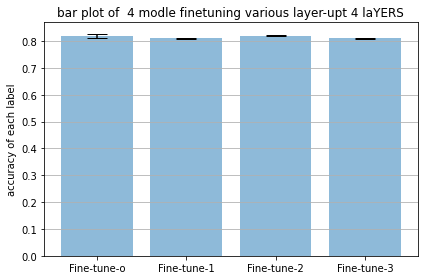

In [163]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_positon, b_height,
       yerr=SE,
       #yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('accuracy of each label')
ax.set_xticks(x_positon)
ax.set_xticklabels(labels)
ax.set_title('bar plot of  4 modle finetuning various layer-upt 4 layers')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()